[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune Qwen2.5-VL on JSON Data Extraction Dataset

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/QwenLM/Qwen2.5-VL)

Qwen2.5-VL is the latest vision-language model in the Qwen series, delivering state-of-the-art capabilities for understanding and analyzing images, text, and documents. Available in three sizes (3B, 7B, and 72B), it excels in tasks such as precise object localization with bounding boxes, enhanced OCR for multi-language and multi-orientation text recognition, and structured data extraction from formats like invoices, forms, and tables. With advanced image recognition spanning plants, animals, landmarks, and products, Qwen2.5-VL sets a new benchmark for multimodal understanding, catering to diverse domains including finance, commerce, and digital intelligence.

Designed for efficiency and accuracy, Qwen2.5-VL introduces innovations such as enhanced visual encoders with dynamic resolution ViT and Window Attention for computational efficiency. The 72B-Instruct model achieves competitive performance in benchmarks like document understanding and reasoning, outperforming models of similar sizes without task-specific fine-tuning. The smaller 3B and 7B models provide edge AI solutions while improving upon previous iterations, making Qwen2.5-VL a versatile choice for a wide range of vision-language applications.

![Qwen2.5-VL](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/qwen2.5vl_arc.jpeg)

## Environment setup

### Configure your API keys

To fine-tune Qwen2.5-VL, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Feb  4 19:05:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             16W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q git+https://github.com/huggingface/transformers accelerate peft bitsandbytes qwen-vl-utils[decord]==0.0.8

You should consider upgrading via the '/home/matveipopov/.pyenv/versions/3.10.1/envs/codetrenv/bin/python -m pip install --upgrade pip' command.


## Download and prepare dataset

In [3]:
!pip install -q roboflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.1.2 requires requests~=2.28.2, but you have requests 2.32.3 which is incompatible.
openxlab 0.1.2 requires rich~=13.4.2, but you have rich 13.0.1 which is incompatible.
You should consider upgrading via the '/home/matveipopov/.pyenv/versions/3.10.1/envs/codetrenv/bin/python -m pip install --upgrade pip' command.


In [9]:
#from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = "zaRavHwbvIXpGerDM3wi"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("pallet-load-manifest-json")
version = project.version(2)
dataset = version.download("jsonl")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pallet-load-manifest-json-2 in jsonl:: 100%|██████████| 178/178 [00:00<00:00, 5796.07it/s]


In [10]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_3128_jpg.rf.050d52dec36d353a43a9eba664c28ad3.jpg","prefix":"<JSON>","suffix":"{\"route\": \"D452-SU-275\",\"pallet_number\": \"15\",\"delivery_date\": \"1/11/2024\",\"load\": \"1\",\"dock\": \"D05\",\"shipment_id\": \"K77912144793\",\"destination\": \"82135 Robert Harbors Apt. 285, Marquezhaven, AZ 68208\",\"asn_number\": \"1338742991\",\"salesman\": \"KIMBERLY GARCIA\",\"products\": [{\"description\": \"223606 - CASE OF MICROFIBER SPONGES\",\"cases\": \"4\",\"sales_units\": \"4\",\"layers\": \"5\"},{\"description\": \"728495 - BOX OF STAIN REMOVERS\",\"cases\": \"64\",\"sales_units\": \"2\",\"layers\": \"4\"},{\"description\": \"112233 - CASE OF DISH SOAP\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"1\"},{\"description\": \"847395 - CASE OF SQUEEGEES\",\"cases\": \"4\",\"sales_units\": \"32\",\"layers\": \"1\"},{\"description\": \"963741 - 12PK OF DISINFECTANT WIPES\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"2\"},{\"description\": \"258963 - CASE 

In [11]:
!sed -i 's/<JSON>/extract data in JSON format/g' {dataset.location}/train/annotations.jsonl
!sed -i 's/<JSON>/extract data in JSON format/g' {dataset.location}/valid/annotations.jsonl
!sed -i 's/<JSON>/extract data in JSON format/g' {dataset.location}/test/annotations.jsonl

In [12]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_3128_jpg.rf.050d52dec36d353a43a9eba664c28ad3.jpg","prefix":"extract data in JSON format","suffix":"{\"route\": \"D452-SU-275\",\"pallet_number\": \"15\",\"delivery_date\": \"1/11/2024\",\"load\": \"1\",\"dock\": \"D05\",\"shipment_id\": \"K77912144793\",\"destination\": \"82135 Robert Harbors Apt. 285, Marquezhaven, AZ 68208\",\"asn_number\": \"1338742991\",\"salesman\": \"KIMBERLY GARCIA\",\"products\": [{\"description\": \"223606 - CASE OF MICROFIBER SPONGES\",\"cases\": \"4\",\"sales_units\": \"4\",\"layers\": \"5\"},{\"description\": \"728495 - BOX OF STAIN REMOVERS\",\"cases\": \"64\",\"sales_units\": \"2\",\"layers\": \"4\"},{\"description\": \"112233 - CASE OF DISH SOAP\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"1\"},{\"description\": \"847395 - CASE OF SQUEEGEES\",\"cases\": \"4\",\"sales_units\": \"32\",\"layers\": \"1\"},{\"description\": \"963741 - 12PK OF DISINFECTANT WIPES\",\"cases\": \"8\",\"sales_units\": \"2\",\"layers\": \"2\"},{\"descriptio

## Data formatting

In [13]:
SYSTEM_MESSAGE = """You are a Vision Language Model specialized in extracting structured data from visual representations of palette manifests.
Your task is to analyze the provided image of a palette manifest and extract the relevant information into a well-structured JSON format.
The palette manifest includes details such as item names, quantities, dimensions, weights, and other attributes.
Focus on identifying key data fields and ensuring the output adheres to the requested JSON structure.
Provide only the JSON output based on the extracted information. Avoid additional explanations or comments."""

In [14]:
def format_data(image_directory_path, entry):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": SYSTEM_MESSAGE}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_directory_path + "/" + entry["image"],
                },
                {
                    "type": "text",
                    "text": entry["prefix"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": entry["suffix"]}],
        },
    ]


In [15]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry, format_data(self.image_directory_path, entry)

In [16]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/train/annotations.jsonl",
    image_directory_path=f"{dataset.location}/train",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path=f"{dataset.location}/valid",
)
test_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/test/annotations.jsonl",
    image_directory_path=f"{dataset.location}/test",
)

In [17]:
train_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 {'image': 'IMG_3128_jpg.rf.050d52dec36d353a43a9eba664c28ad3.jpg',
  'prefix': 'extract data in JSON format',
  'suffix': '{"route": "D452-SU-275","pallet_number": "15","delivery_date": "1/11/2024","load": "1","dock": "D05","shipment_id": "K77912144793","destination": "82135 Robert Harbors Apt. 285, Marquezhaven, AZ 68208","asn_number": "1338742991","salesman": "KIMBERLY GARCIA","products": [{"description": "223606 - CASE OF MICROFIBER SPONGES","cases": "4","sales_units": "4","layers": "5"},{"description": "728495 - BOX OF STAIN REMOVERS","cases": "64","sales_units": "2","layers": "4"},{"description": "112233 - CASE OF DISH SOAP","cases": "8","sales_units": "2","layers": "1"},{"description": "847395 - CASE OF SQUEEGEES","cases": "4","sales_units": "32","layers": "1"},{"description": "963741 - 12PK OF DISINFECTANT WIPES","cases": "8","sales_units": "2","layers": "2"},{"description": "258963 - CASE OF MULTI-SURFACE SPRAY",

## Model loading and configuration

In this section, we load the **Qwen2.5-VL** model with optional **LoRA** (Low-Rank Adaptation) or **QLoRA** (Quantized LoRA). LoRA injects small trainable weights (the “low-rank matrices”) into the model’s layers, saving significant memory and compute compared to fine-tuning the entire model. QLoRA further applies **4-bit quantization** to reduce memory usage while still preserving much of the model’s performance.

In [20]:
import torch

from peft import get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor


MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_QLORA = True


lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)


if USE_QLORA:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_type=torch.bfloat16
    )


model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    device_map="auto",
    quantization_config=bnb_config if USE_QLORA else None,
    torch_dtype=torch.bfloat16)


model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Unused kwargs: ['bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


The model supports a wide range of resolution inputs. By default, it uses the native resolution for input, but higher resolutions can enhance performance at the cost of more computation. Users can set the minimum and maximum number of pixels to achieve an optimal configuration for their needs, such as a token count range of 256-1280, to balance speed and memory usage.

In [21]:
MIN_PIXELS = 256 * 28 * 28
MAX_PIXELS = 1280 * 28 * 28

processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID, min_pixels=MIN_PIXELS, max_pixels=MAX_PIXELS)

## Data collation and tokenization

### Train Collate Function
We use a masking technique that replaces padding tokens, special image tokens, and tokens from system and user turns with -100 so that the loss function ignores them and only evaluates the assistant's response.

In [22]:
from qwen_vl_utils import process_vision_info


def train_collate_fn(batch):
    _, _, examples = zip(*batch)

    texts = [
        processor.apply_chat_template(example, tokenize=False)
        for example
        in examples
    ]
    image_inputs = [
        process_vision_info(example)[0]
        for example
        in examples
    ]

    model_inputs = processor(
        text=texts,
        images=image_inputs,
        return_tensors="pt",
        padding=True
    )

    labels = model_inputs["input_ids"].clone()

    # mask padding tokens in labels
    labels[labels == processor.tokenizer.pad_token_id] = -100

    if isinstance(processor, Qwen2_5_VLProcessor):
        image_tokens = [151652, 151653, 151655]
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]

    # mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100

    # Mask these tokens so that the loss is computed only for assistant tokens.
    for i, example in enumerate(examples):
        sysuser_conv = example[:-1]
        sysuser_text = processor.apply_chat_template(sysuser_conv, tokenize=False)
        sysuser_img, _ = process_vision_info(sysuser_conv)
        
        sysuser_inputs = processor(
            text=[sysuser_text],
            images=[sysuser_img],
            return_tensors="pt",
            padding=True,
        )
        
        sysuser_len = sysuser_inputs["input_ids"].shape[1]
        labels[i, :sysuser_len] = -100

    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]
    image_grid_thw = model_inputs["image_grid_thw"]

    return input_ids, attention_mask, pixel_values, image_grid_thw, labels

### Evaluation Collate Function

In the evaluation function, we separate out the suffixes (i.e., ground-truth target text) for later comparison. The line `examples = [e[:2] for e in examples]` effectively drops the assistant’s final turn from the template so that we only feed the model system + user and then generate the assistant output ourselves.

In [23]:
def evaluation_collate_fn(batch):
    _, data, examples = zip(*batch)
    suffixes = [d["suffix"] for d in data]

    # drop the assistant portion so the model must generate it
    examples = [e[:2] for e in examples]

    texts = [
        processor.apply_chat_template(example, tokenize=False)
        for example
        in examples
    ]
    image_inputs = [
        process_vision_info(example)[0]
        for example
        in examples
    ]

    model_inputs = processor(
        text=texts,
        images=image_inputs,
        return_tensors="pt",
        padding=True
    )

    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]
    image_grid_thw = model_inputs["image_grid_thw"]

    return input_ids, attention_mask, pixel_values, image_grid_thw, suffixes

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=train_collate_fn, num_workers=NUM_WORKERS, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=evaluation_collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=evaluation_collate_fn, num_workers=NUM_WORKERS)

In [25]:
input_ids, attention_mask, pixel_values, image_grid_thw, labels = next(iter(train_loader))

In [26]:
input_ids

tensor([[151644,   8948,    198,  ...,   9207, 151645,    198]])

In [27]:
processor.batch_decode(input_ids)

['<|im_start|>system\nYou are a Vision Language Model specialized in extracting structured data from visual representations of palette manifests.\nYour task is to analyze the provided image of a palette manifest and extract the relevant information into a well-structured JSON format.\nThe palette manifest includes details such as item names, quantities, dimensions, weights, and other attributes.\nFocus on identifying key data fields and ensuring the output adheres to the requested JSON structure.\nProvide only the JSON output based on the extracted information. Avoid additional explanations or comments.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|imag

In [28]:
torch.set_printoptions(profile="full")

In [30]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [32]:
labels

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -

In [33]:
for input_id, label in zip(input_ids[0], labels[0]):
    print(processor.decode(input_id), label.item() if label.item() == -100 else processor.decode(label))

<|im_start|> -100
system -100

 -100
You -100
 are -100
 a -100
 Vision -100
 Language -100
 Model -100
 specialized -100
 in -100
 extracting -100
 structured -100
 data -100
 from -100
 visual -100
 representations -100
 of -100
 palette -100
 manifests -100
.
 -100
Your -100
 task -100
 is -100
 to -100
 analyze -100
 the -100
 provided -100
 image -100
 of -100
 a -100
 palette -100
 manifest -100
 and -100
 extract -100
 the -100
 relevant -100
 information -100
 into -100
 a -100
 well -100
- -100
structured -100
 JSON -100
 format -100
.
 -100
The -100
 palette -100
 manifest -100
 includes -100
 details -100
 such -100
 as -100
 item -100
 names -100
, -100
 quantities -100
, -100
 dimensions -100
, -100
 weights -100
, -100
 and -100
 other -100
 attributes -100
.
 -100
Focus -100
 on -100
 identifying -100
 key -100
 data -100
 fields -100
 and -100
 ensuring -100
 the -100
 output -100
 adher -100
es -100
 to -100
 the -100
 requested -100
 JSON -100
 structure -100
.
 -100


In [34]:
input_ids, attention_mask, pixel_values, image_grid_thw, suffixes = next(iter(valid_loader))

In [35]:
input_ids

tensor([[151644,   8948,    198,   2610,    525,    264,  30441,  11434,   4903,
          27076,    304,  59408,  32930,    821,    504,   9124,  43613,    315,
          26308,  83232,    624,   7771,   3383,    374,    311,  23643,    279,
           3897,   2168,    315,    264,  26308,  14455,    323,   8649,    279,
           9760,   1995,   1119,    264,   1632,     12,  51143,   4718,   3561,
            624,    785,  26308,  14455,   5646,   3565,   1741,    438,   1509,
           5036,     11,  32676,     11,  15336,     11,  14324,     11,    323,
           1008,   8201,    624,  13819,    389,  24588,   1376,    821,   5043,
            323,  22573,    279,   2550,  34951,    288,    311,    279,  11223,
           4718,   5944,    624,  60424,   1172,    279,   4718,   2550,   3118,
            389,    279,  27432,   1995,     13,  34006,   5107,  40841,    476,
           6042,     13, 151645,    198, 151644,    872,    198, 151652, 151655,
         151655, 151655, 151

In [36]:
processor.batch_decode(input_ids)

['<|im_start|>system\nYou are a Vision Language Model specialized in extracting structured data from visual representations of palette manifests.\nYour task is to analyze the provided image of a palette manifest and extract the relevant information into a well-structured JSON format.\nThe palette manifest includes details such as item names, quantities, dimensions, weights, and other attributes.\nFocus on identifying key data fields and ensuring the output adheres to the requested JSON structure.\nProvide only the JSON output based on the extracted information. Avoid additional explanations or comments.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|imag

## Training with PyTorch Lightning

In [37]:
!pip install -q lightning nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/home/matveipopov/.pyenv/versions/3.10.1/envs/codetrenv/bin/python -m pip install --upgrade pip' command.


The `edit_distance` (from `nltk`) measures how many character-level edits (insertion, deletion, substitution) are needed to transform the predicted text into the ground truth. We normalize it by the length of the longer string to get a score between 0 (identical) and 1 (completely different).

In [38]:
import lightning as L
from nltk import edit_distance
from torch.optim import AdamW


class Qwen2_5_Trainer(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, pixel_values, image_grid_thw, labels = batch
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            image_grid_thw=image_grid_thw,
            labels=labels
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        input_ids, attention_mask, pixel_values, image_grid_thw, suffixes = batch
        generated_ids = self.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            image_grid_thw=image_grid_thw,
            max_new_tokens=1024
        )
        generated_ids_trimmed = [
            out_ids[len(in_ids) :]
            for in_ids, out_ids
            in zip(input_ids, generated_ids)]

        generated_suffixes = processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )

        scores = []
        for generated_suffix, suffix in zip(generated_suffixes, suffixes):
            score = edit_distance(generated_suffix, suffix)
            score = score / max(len(generated_suffix), len(suffix))
            scores.append(score)

            print("generated_suffix", generated_suffix)
            print("suffix", suffix)
            print("score", score)

        score = sum(scores) / len(scores)
        self.log("val_edit_distance", score, prog_bar=True, logger=True, batch_size=self.config.get("batch_size"))
        return scores

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.config.get("lr"))
        return optimizer

    def train_dataloader(self):
        return DataLoader(
            train_dataset,
            batch_size=self.config.get("batch_size"),
            collate_fn=train_collate_fn,
            shuffle=True,
            num_workers=10,
        )

    def val_dataloader(self):
        return DataLoader(
            valid_dataset,
            batch_size=self.config.get("batch_size"),
            collate_fn=evaluation_collate_fn,
            num_workers=10,
        )

In [39]:
config = {
    "max_epochs": 10,
    "batch_size": 4,
    "lr": 2e-4,
    "check_val_every_n_epoch": 2,
    "gradient_clip_val": 1.0,
    "accumulate_grad_batches": 8,
    "num_nodes": 1,
    "warmup_steps": 50,
    "result_path": "qwen2.5-3b-instruct-palette-manifest"
}

In [40]:
model_module = Qwen2_5_Trainer(config, processor, model)

In [41]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stopping_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")


class SaveCheckpoint(Callback):
    def __init__(self, result_path):
        self.result_path = result_path
        self.epoch = 0

    def on_train_epoch_end(self, trainer, pl_module):
        checkpoint_path = f"{self.result_path}/{self.epoch}"
        os.makedirs(checkpoint_path, exist_ok=True)

        pl_module.processor.save_pretrained(checkpoint_path)
        pl_module.model.save_pretrained(checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

        self.epoch += 1

    def on_train_end(self, trainer, pl_module):
        checkpoint_path = f"{self.result_path}/latest"
        os.makedirs(checkpoint_path, exist_ok=True)

        pl_module.processor.save_pretrained(checkpoint_path)
        pl_module.model.save_pretrained(checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

In [ ]:
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=config.get("max_epochs"),
    accumulate_grad_batches=config.get("accumulate_grad_batches"),
    check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
    gradient_clip_val=config.get("gradient_clip_val"),
    limit_val_batches=1,
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    callbacks=[SaveCheckpoint(result_path=config["result_path"]), early_stopping_callback],
)

trainer.fit(model_module)

### Run inference with fine-tuned Qwen2.5-VL model

In [39]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "/content/qwen2.5-3b-instruct-palette-manifest/latest",
    device_map="auto",
    torch_dtype=torch.bfloat16
)

processor = Qwen2_5_VLProcessor.from_pretrained(
    "/content/qwen2.5-3b-instruct-palette-manifest/latest",
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [44]:
def run_inference(model, processor, conversation, max_new_tokens=1024, device="cuda"):
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=[text],
        images=image_inputs,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids
        in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    return output_text[0]

In [51]:
image, entry, conversation = test_dataset[0]
conversation = conversation[:2]
suffix = entry["suffix"]
suffix

'{"route": "J414-YG-624","pallet_number": "17","delivery_date": "9/18/2024","load": "1","dock": "D08","shipment_id": "P18941494362","destination": "595 Navarro Radial Suite 559, Port Erika, HI 29655","asn_number": "4690787672","salesman": "CAROL FREDERICK","products": [{"description": "159753 - BOX OF PAPER CUPS","cases": "32","sales_units": "8","layers": "2"},{"description": "583947 - BOX OF CLOTH RAGS","cases": "8","sales_units": "2","layers": "5"},{"description": "357951 - 6PK OF HAND SANITIZER","cases": "2","sales_units": "32","layers": "4"},{"description": "847295 - CASE OF DISPOSABLE CAPS","cases": "16","sales_units": "4","layers": "3"}],"total_cases": "58","total_units": "46","total_layers": "14","printed_date": "12/05/2024 10:14","page_number": "60"}'

In [46]:
generated_suffix = run_inference(model, processor, conversation)
generated_suffix

'{"route": "J414-YG-624","pallet_number": "17","load": "1","delivery_date": "9/18/2024","shipment_id": "P18941494362","destination": "595 Navarro Radial Suite 559, Port Erika, HI 29655","asn_number": "4690787672","dock": "D08","salesman": "CAROL FREDERICK","products": [{"description": "159753 - BOX OF PAPER CUPS","cases": "32","sales_units": "8","layers": "2"},{"description": "583947 - BOX OF CLOTH RAGS","cases": "8","sales_units": "2","layers": "5"},{"description": "357951 - 6PK OF HAND SANITIZER","cases": "2","sales_units": "32","layers": "4"},{"description": "847295 - CASE OF DISPOSABLE CAPS","cases": "16","sales_units": "4","layers": "3"}],"total_cases": "46","total_units": "14","printed_date": "12/05/2024 10:14","page_number": "60"}'

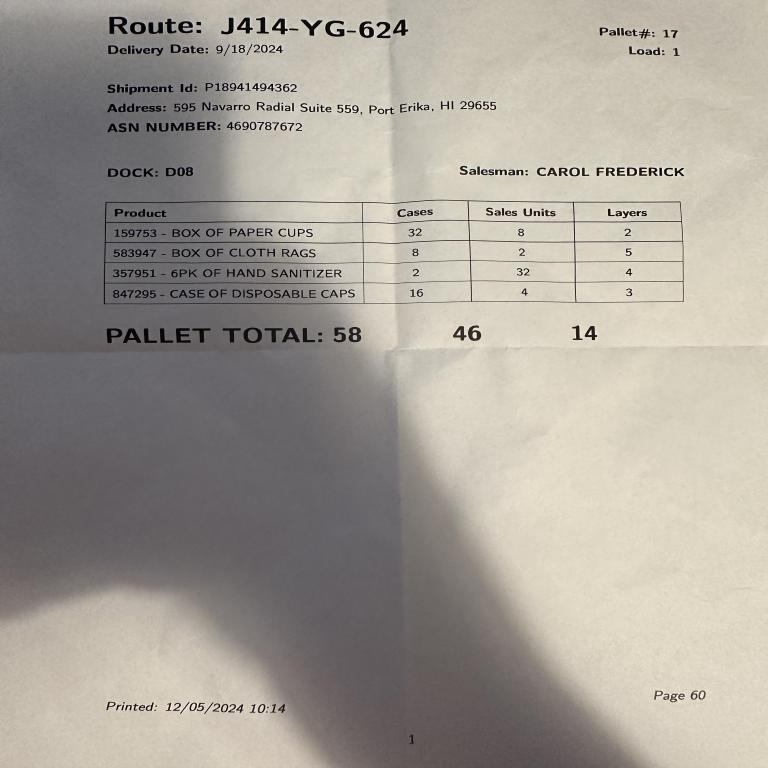

In [48]:
image

In [49]:
from difflib import SequenceMatcher
from IPython.core.display import display, HTML

def side_by_side_diff_divs(text1, text2):
    lines1 = text1.splitlines()
    lines2 = text2.splitlines()

    original_output = []
    modified_output = []

    for line1, line2 in zip(lines1, lines2):
        words1 = line1.split()
        words2 = line2.split()

        matcher = SequenceMatcher(None, words1, words2)

        original_line = []
        modified_line = []

        for tag, i1, i2, j1, j2 in matcher.get_opcodes():
            if tag == 'replace':
                original_line.append(f"<span class='diff-remove'>{' '.join(words1[i1:i2])}</span>")
                modified_line.append(f"<span class='diff-add'>{' '.join(words2[j1:j2])}</span>")
            elif tag == 'delete':
                original_line.append(f"<span class='diff-remove'>{' '.join(words1[i1:i2])}</span>")
            elif tag == 'insert':
                modified_line.append(f"<span class='diff-add'>{' '.join(words2[j1:j2])}</span>")
            elif tag == 'equal':
                original_line.append(' '.join(words1[i1:i2]))
                modified_line.append(' '.join(words2[j1:j2]))

        original_output.append(' '.join(original_line) + "<br>")
        modified_output.append(' '.join(modified_line) + "<br>")

    original_html = "<br>" + ''.join(original_output) + "<br>"
    modified_html = "<br>" + ''.join(modified_output) + "<br>"

    html = f"""
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 0; padding: 0; }}
            .container {{ display: flex; align-items: flex-start; }}
            .column {{
                flex: 1;
                padding: 10px;
                white-space: pre-wrap;
                text-align: left;
            }}
            .diff-remove {{
                background-color: #d9534f;  /* Dark red */
                color: white;
                text-decoration: line-through;
                border-radius: 4px;
                padding: 2px 4px;
            }}
            .diff-add {{
                background-color: #5cb85c;  /* Dark green */
                color: white;
                border-radius: 4px;
                padding: 2px 4px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="column" style="border-right: 1px solid #ccc;">
                {original_html}
            </div>
            <div class="column">
                {modified_html}
            </div>
        </div>
    </body>
    </html>
    """
    return html

In [50]:
html_diff = side_by_side_diff_divs(suffix, generated_suffix)
display(HTML(html_diff))